In [2]:
import sys 
import os
# sys.path = []
sys.path.insert(1,os.path.abspath("../src/"))
sys.path.insert(1,os.path.abspath("../src/finn/"))
sys.path.insert(1,os.path.abspath("../src/qonnx/"))
# print(sys.path)
clean_sys_path = sys.path

def print_name(key):
    print("--"*20,key, "--"*20)    

In [51]:
from qonnx.core.modelwrapper import ModelWrapper
from onnxruntime_extensions import get_library_path
import onnxruntime as ort
from custom_ort_functions import DoubleToSingleFloat, set_multithreshold_default

model_0 = ModelWrapper("../models/Conv/Conv_10_out0/partition_0.onnx")
# model_0 = ModelWrapper("../models/mobilenet_streamline.onnx")
model = set_multithreshold_default(model_0)

so = ort.SessionOptions()
so.register_custom_ops_library(get_library_path())
sess = ort.InferenceSession(model.model.SerializeToString(),so)

inp_name = sess.get_inputs()[0].name
inp_shape = sess.get_inputs()[0].shape

print(inp_shape)

[1, 3, 224, 224]


In [52]:
model = ModelWrapper("../models/mobilenet_streamline.onnx")
from qonnx.transformation.create_generic_partitions import PartitionFromDict
from qonnx.util.basic import get_by_name
upstream_0 = model.find_upstream("Conv_10_out0", lambda x: x.name == "Conv_0")
wanted_nodes = []
unwanted_nodes = []
for ind, node in enumerate(model.graph.node):
    found_0 = get_by_name(upstream_0, node.name, "name") is not None
    if found_0:
        wanted_nodes.append(ind)
    else:
        unwanted_nodes.append(ind)
parent=model.transform(PartitionFromDict(
    partitioning={ 0 : wanted_nodes, 1 : unwanted_nodes },
    partition_dir="temp"
    ))
# parent.save(cfg.output_dir + "/intermediate_models/partition_parent.onnx")
parent.save("model_conv_10.onnx")

model = set_multithreshold_default(ModelWrapper("temp/partition_0.onnx"))
# model.graph
so = ort.SessionOptions()
so.register_custom_ops_library(get_library_path())
sess_1 = ort.InferenceSession(model.model.SerializeToString(),so)

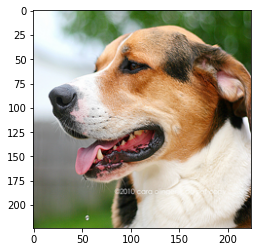

In [54]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open("../imagenet/dog.JPEG")
img = img.resize([224,224])
plt.imshow(img)
n_chn = len(img.split())
x = np.array(img,dtype=np.float32).reshape(inp_shape)
np.save("../imagenet/dog.npy",x.reshape(1,224,224,3))

inp_dict = {inp_name: x}
res = sess.run([],inp_dict)
y_ort_0 = np.array(res[0])

res1 = sess_1.run([],inp_dict)
y_ort_1 = np.array(res[0])

dog = os.path.abspath("../imagenet/dog.npy")


In [5]:
# ! cat ../models/Conv/Conv_10_out0/driver/driver.py
exe = True
if exe:
    ! python ../models/Conv/Conv_10_out0/driver/driver.py --bitfile=../models/Conv/Conv_10_out0/bitfile/finn-accel.bit --inputfile={dog}

In [57]:
import random
# outputs = np.load('output.npy')
# outputs = np.reshape(outputs,y_ort.shape)
for ref_o, o in zip(y_ort_0, y_ort_1):
    print(np.testing.assert_almost_equal(ref_o, o, 1))

None


# Create dummy inputs and store in the correct model directory 
For the moment want to create dummy input data, and keep this constant such that it does not change. Use this data to verify that the hw + cpu run has the same output as the expected output.


In [97]:
import numpy as np
import os
import shutil

clear_data = False

# Create a directory with relative info
model_dict = {}

# Get the onnx model directory
md = os.path.abspath("../models")
op_type = "Conv"

# Get the model hw directory where the driver file is located.
build_dir = os.path.abspath("../build-KV260/")

# Get split names for created hw files
split_dirs = [s for s in os.listdir(os.path.join(build_dir,op_type))]

# Fill the model dict
for split_name in split_dirs:
    print_name(split_name)
    model_base_folder = os.path.join(md,op_type,split_name)
    driver_dir = os.path.join(model_base_folder,"driver")
    bitfile_dir = os.path.join(model_base_folder,"bitfile")
    data_dir = os.path.join(model_base_folder,"data")
    if clear_data:
        try:
            shutil.rmtree(data_dir)
            shutil.rmtree(bitfile_dir)
            shutil.rmtree(driver_dir)
        except OSError as e:
            pass        
    else:
        shutil.copytree(os.path.join(build_dir,op_type,split_name,"deploy"),
                        model_base_folder, 
                        dirs_exist_ok=True
                       )
        
    ! ls {model_base_folder}
    model_dict[split_name.replace('_out0','')] = {"model_dir": model_base_folder, 
                                                  "driver_dir": driver_dir, 
                                                  "bitfile_dir":bitfile_dir,
                                                  "data_dir": data_dir}

---------------------------------------- Conv_6_out0 ----------------------------------------
bitfile  driver		   partition_0_ort.onnx  partition_1_ort.onnx
data	 partition_0.onnx  partition_1.onnx
---------------------------------------- Conv_10_out0 ----------------------------------------
bitfile  driver		   partition_0_ort.onnx  partition_1_ort.onnx
data	 partition_0.onnx  partition_1.onnx
---------------------------------------- Conv_0_out0 ----------------------------------------
bitfile  driver		   partition_0_ort.onnx  partition_1_ort.onnx
data	 partition_0.onnx  partition_1.onnx
---------------------------------------- Conv_2_out0 ----------------------------------------
bitfile  driver		   partition_0_ort.onnx  partition_1_ort.onnx
data	 partition_0.onnx  partition_1.onnx
---------------------------------------- Conv_4_out0 ----------------------------------------
bitfile  driver		   partition_0_ort.onnx  partition_1_ort.onnx
data	 partition_0.onnx  partition_1.onnx
---------

##### Eventually want to supply a image and see the output

In [116]:
# Create dummy data for the moment
for k,v in model_dict.items():
    sd = v["data_dir"]
    if not os.path.exists(sd):
        os.mkdir(sd)
        x = np.random.random([1,3,224,224])
        np.save(f"{sd}/{k}_input.npy",x)
        v["data_dir"] = sd
    ! ls {v["data_dir"]}

Conv_6_gld_output.npy  Conv_6_hw_output.npy  Conv_6_output.npy
Conv_6_hw_input.npy    Conv_6_input.npy
Conv_10_gld_output.npy	Conv_10_hw_output.npy  Conv_10_output.npy
Conv_10_hw_input.npy	Conv_10_input.npy
Conv_0_gld_output.npy  Conv_0_hw_output.npy  Conv_0_output.npy
Conv_0_hw_input.npy    Conv_0_input.npy
Conv_2_gld_output.npy  Conv_2_hw_output.npy  Conv_2_output.npy
Conv_2_hw_input.npy    Conv_2_input.npy
Conv_4_gld_output.npy  Conv_4_hw_output.npy  Conv_4_output.npy
Conv_4_hw_input.npy    Conv_4_input.npy
Conv_8_gld_output.npy  Conv_8_hw_output.npy  Conv_8_output.npy
Conv_8_hw_input.npy    Conv_8_input.npy


# Get golden output 
For each of the inputs get the expected output from the baseline model

In [124]:
from qonnx.core.modelwrapper import ModelWrapper
from onnxruntime_extensions import get_library_path
import onnxruntime as ort
# from custom_ort_functions import set_multithreshold_default

# Load input streamlined model
mf = os.path.abspath("../models/mobilenet_streamline.onnx")
model = ModelWrapper(mf)
# model = model.transform(DoubleToSingleFloat())
set_multithreshold_default(model,mf.replace('.onnx',"_ort.onnx"))

# Set up a session for 
so = ort.SessionOptions()
so.register_custom_ops_library(get_library_path())
sess = ort.InferenceSession(mf.replace('.onnx',"_ort.onnx"), so)
print(sess.get_inputs()[0].shape)

for k,v in model_dict.items():
    data_dir = v["data_dir"]
#     x = np.load(f"{data_dir}/{k}_input.npy")
    x = np.random.random([1,3,224,224])
    inp_dict = {sess.get_inputs()[0].name: x.astype(np.float32)}
    _gld_res = sess.run([],inp_dict)
    print(_gld_res)
    np.save(f"{data_dir}/{k}_gld_output.npy",_gld_res)
#     ! ls {data_dir}

[1, 3, 224, 224]
[array([[644, 818, 530, 111, 626]], dtype=int64)]
[array([[644, 818, 111, 530, 626]], dtype=int64)]
[array([[644, 818, 111, 530, 626]], dtype=int64)]
[array([[644, 818, 530, 111, 626]], dtype=int64)]
[array([[644, 818, 530, 111, 626]], dtype=int64)]
[array([[644, 818, 530, 626, 111]], dtype=int64)]


# Perform the hardware run for the dummy data

In [98]:
for k,v in model_dict.items():
    print_name(k)
    x = os.path.join(v['data_dir'],f"{k}_input.npy")
    y = os.path.join(v['data_dir'],f"{k}_hw_output.npy")
#     ! ls {v["bitfile_dir"]}
    x_hw = np.load(x).reshape((1, 224, 224, 3))
    x_hw_f =os.path.join(v['data_dir'],f"{k}_hw_input.npy") 
    np.save(x_hw_f,x_hw)
    if not os.path.isfile(y):
        ! python {v["driver_dir"]}/driver.py --inputfile={x_hw_f} --outputfile={y} --bitfile={v["bitfile_dir"]}/finn-accel.bit
    y_hw = np.load(y)
    print(y_hw.shape)

---------------------------------------- Conv_6 ----------------------------------------
(1, 56, 56, 128)
---------------------------------------- Conv_10 ----------------------------------------
(1, 28, 28, 256)
---------------------------------------- Conv_0 ----------------------------------------
(1, 111, 111, 32)
---------------------------------------- Conv_2 ----------------------------------------
(1, 111, 111, 64)
---------------------------------------- Conv_4 ----------------------------------------
(1, 56, 56, 128)
---------------------------------------- Conv_8 ----------------------------------------
(1, 28, 28, 256)


In [108]:
for k,v in model_dict.items():
#     Get hw output
    y_hw = np.load(v['data_dir'] + f'/{k}_hw_output.npy')
#     Create a ort session
    mf = v['model_dir']+'/partition_1.onnx'
    mf_update = mf.replace('.onnx','_ort.onnx')

    set_multithreshold_default(ModelWrapper(mf),mf_update)

    so = ort.SessionOptions()
    
    so.register_custom_ops_library(get_library_path())
    sess = ort.InferenceSession(mf_update, so)
    x_cpu = y_hw.reshape(sess.get_inputs()[0].shape)
    inp_dict = {sess.get_inputs()[0].name: x_cpu}
    y = sess.run([],inp_dict)
    np.save(os.path.join(v['data_dir'],f"{k}_output.npy"),y)

# Functional verification

In [58]:
for k,v in model_dict.items():
#     ! ls {v['data_dir']}
    out = v['data_dir']+f"/{k}_output.npy"
    gld = v['data_dir']+f"/{k}_gld_output.npy"
    print_name(k)
    gld = np.load(gld)
    out = np.load(out)
    print(gld,out)

NameError: name 'model_dict' is not defined